# Ce projet part d'une simple observation : les filtres instagram

# Le but de ce projet et d'essayer de recréer un filtre qui track un visage à l'aide de MTCNN

# Importation des librairies

In [1]:
import cv2
import time
# example of face detection with mtcnn
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import numpy as np
import matplotlib.pyplot as plt
import math

## bibliothèques pour enlever le fond
from rembg import remove

2024-04-07 19:21:16.850632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Utilisation de MTCNN pour détecter le visage et récupérer les coordonnées

In [7]:
def extract_face(images, face, x1, x2, y1, y2, yr, yl):
    pixels = images
    
    # on crée le détecteur de visage
    detector = MTCNN()
    
    # le result nous donne la délimitation du visage reconnu
    results = detector.detect_faces(pixels)
    
    print(results[0])
    
    # on vérifie qu'il a bien détecté un visage
    if len(results) != 0:
        yr = results[0]['keypoints']['right_eye']
        yl = results[0]['keypoints']['left_eye']
        
        #yl = (yl[0]-10, yl[1])
        #yr = (yr[0]+10, yr[1])
        
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height

        
## on renvoie le visage centré et les coordonnées de sa délimitation par rapport à l'image d'entrée
        return pixels, x1, x2, y1, y2, yr, yl

## si le visage n'a pas été reconnu, on renvoie le précédent 
    return face, x1, x2, y1, y2, yr, yl


# On définit une fonction qui va créer une zone rectangulaire autour des yeux pour y placer des lunettes par exemple

In [8]:
def zone_lunette(yr, yl,x1, x2, y1, y2):
    
    ## dimension de la box pour avoir les proportions du visage
    
    height = y2 - y1
    width = x2 - x1
    prop_h = height//7
    prop_w = width//2
    large_eye = yr[0] - yl[0]
    
    ## on fixe la bounding box des yeux sur l'oeil le plus bas
    ## on renvoie : x1, x2 (abscisses), y1, y2 (ordonnées)
    
    if yr[1] > yl[1]:   
        return (yr[0]+prop_w//2, yr[0]- prop_w//2 -large_eye, yr[1]-prop_h//2, yr[1]+prop_h//2)
        
    return (yl[0] - prop_w//2, yl[0]+ prop_w//2 + large_eye, yl[1]-prop_h//2, yl[1]+prop_h//2)



# On test le modèle MTCNN sur une image et on tente de récupérer les coordonnées de la bounding boxes et des yeux

1/1 [==============================] - 0s 81ms/step
{'box': [254, 146, 95, 116], 'confidence': 0.9998804330825806, 'keypoints': {'left_eye': (295, 196), 'right_eye': (333, 200), 'nose': (316, 230), 'mouth_left': (283, 236), 'mouth_right': (316, 238)}}
356 272 192 208


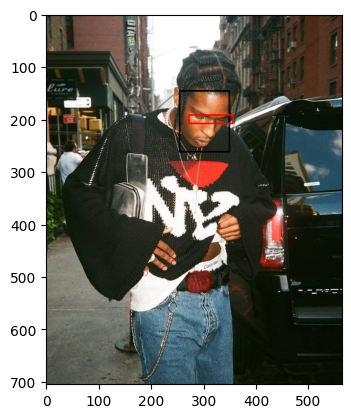

In [24]:
#img_test1 = Image.open('/Users/avicenne/Documents/python/cours_imt/projet-mdata/Projet-facial-recognition/asap.jpeg')

img_test = Image.open('/Users/avicenne/Documents/python/computer_vision/asap1.jpeg')

img_test = np.array(img_test)

## on extrait : bounding box et position des yeux
face, x1, x2, y1, y2, yr, yl = extract_face(img_test, None, None, None, None, None, None, None)

## on extrait la délimitation autour des yeux
u1, u2, v1, v2 = zone_lunette(yr, yl,x1, x2, y1, y2)

print(u1, u2, v1, v2)

##on dessine un rectangle qui va délimiter le visage reconnu et les yeux
img_test = cv2.rectangle(img_test, (x1, y1), (x2, y2), (0, 0, 0), 2) 
img_test = cv2.rectangle(img_test, (u1, v1), (u2, v2), (255, 0, 0), 2) 

## point sur les yeux
img_test = cv2.circle(img_test, yr, radius=1, color=(255, 0, 0), thickness=-1)
img_test = cv2.circle(img_test, yl, radius=1, color=(255, 0, 0), thickness=-1)

plt.imshow(img_test)

# On définit ensuite une fonction qui va appliquer une rotation en fonction de l'inclinaison de la tête

In [10]:
def apply_lunette(lunette, u1, u2, v1, v2, yl, yr):
    
    ## on va redimensionner les lunettes en fonction de la box définit autour des yeux
    h_lunette = abs(v2-v1)
    w_lunette = abs(u2-u1)

    new_size = (w_lunette, h_lunette)  # Nouvelle taille
    lunette_resized = lunette.resize(new_size, Image.BICUBIC)
    
    # Règles de trigo : SOHCAHTOA pour calculer le degré de rotation de la tête
    angle_radians = math.asin((yl[1]-yr[1]) / (math.sqrt((yl[0] - yr[0])**2 + (yl[1] - yr[1])**2)))

    # Conversion en degrés
    angle_degres = math.degrees(angle_radians)
            
    # on applique la rotation
    lunette_rotate = lunette_resized.rotate(angle_degres)
    lunette_array = np.array(lunette_rotate)
            

    # Séparer les canaux de l'image des lunettes
    r, g, b, a = cv2.split(lunette_array)
            
    # Appliquer la transparence de l'image des lunettes
    lunette_r = r.astype(float) 
    lunette_g = g.astype(float) 
    lunette_b = b.astype(float) 
    lunette_a = a.astype(float) 

    return lunette_array, a

# On applique le résultat final sur l'image

1/1 [==============================] - 0s 79ms/step
{'box': [73, 43, 64, 90], 'confidence': 0.9999595880508423, 'keypoints': {'left_eye': (89, 79), 'right_eye': (120, 78), 'nose': (106, 96), 'mouth_left': (93, 113), 'mouth_right': (120, 111)}}
1/1 [==============================] - 0s 80ms/step
{'box': [254, 146, 95, 116], 'confidence': 0.9998804330825806, 'keypoints': {'left_eye': (295, 196), 'right_eye': (333, 200), 'nose': (316, 230), 'mouth_left': (283, 236), 'mouth_right': (316, 238)}}


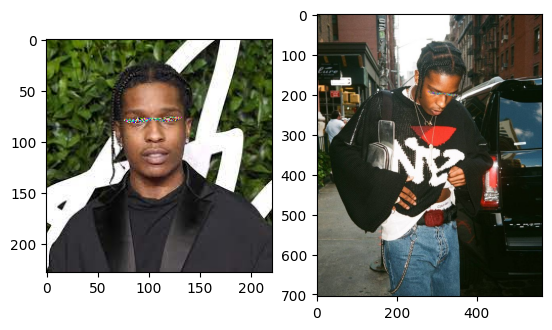

In [41]:

img_test = Image.open('/Users/avicenne/Documents/python/cours_imt/projet-mdata/Projet-facial-recognition/asap.jpeg')
img_test1 = Image.open('/Users/avicenne/Documents/python/computer_vision/asap1.jpeg')

img_test = np.array(img_test)
img_test1 = np.array(img_test1)

images = [img_test, img_test1]


plt.figure()

i = 0
    
for img in images:
    
    i+=1
    
    plt.subplot(1, 2, i)
    
    # Charger les lunettes
    lunette = Image.open('/Users/avicenne/Documents/python/cours_imt/projet-mdata/Projet-facial-recognition/lunette.png')

    # enlever le fond
    lunette = remove(lunette)
    
    
    ## on extrait : bounding box et position des yeux
    face, x1, x2, y1, y2, yr, yl = extract_face(img, None, None, None, None, None, None, None)

    ## on extrait la délimitation autour des yeux
    u1, u2, v1, v2 = zone_lunette(yr, yl,x1, x2, y1, y2)
    

    lunette_array, a = apply_lunette(lunette, u1, u2, v1, v2, yl, yr)

    if u1 > u2:    
        roi = img[v1: v2, u2:u1]
        for c in range(0, 3):
            roi[:, :, c] = (a * lunette_array[:, :, c] + (1.0 - a) * roi[:, :, c])

    else:
        roi = img_test[v1: v2, u1:u2]
        for c in range(0, 3):
            roi[:, :, c] = (a * lunette_array[:, :, c] + (1.0 - a) * roi[:, :, c])


    plt.imshow(img)

    ## on a juste un petit problème au niveau des lunettes qui ne gardent pas la couleur originale


# On peut finalement appliquer ce filtre sur le flux vidéo de webcam

In [ ]:
## algo final : 

def show_webcam(mirror=False):
    lunette = Image.open('/Users/avicenne/Documents/python/cours_imt/projet-mdata/Projet-facial-recognition/lunette.png')
    
    ## on supprime le fond de l'image, un canal est ajouté le canal alpha : (x, y, 4)
    lunette = rembg.remove(lunette)
    
    cam = cv2.VideoCapture(0)
    
    ## on définit les valeurs initiales pour la fonction extract_face qui renvoie le dernier visage détecté
    face = np.zeros((48,48,3), np.uint8)
    x1=0 
    x2=0 
    y1=0 
    y2 = 0
    yr = (0,0)
    yl = (0,0)
    
    while True:
        
        ## image du flux de la webcam
        ret_val, img = cam.read()
        
        ## on vérifie qu'on a une image
        if img.shape != 0:
            
            ##on extrait le visage à partir du flux d'image
            face, x1, x2, y1, y2, yr, yl = extract_face(img, face, x1, x2, y1, y2, yr, yl)
            
            ## on extrait la zone où on va appliquer les lunettes
            u1, u2, v1, v2 = zone_lunette(yr, yl,x1, x2, y1, y2)
            print("u1, u2, v1, v2", u1, u2, v1, v2, "yr, yl", yr, yl) 
            
            ## rotation des lunettes
            lunette_array, a = apply_lunette(lunette, u1, u2, v1, v2, yl, yr)
    
            
            ##on dessine un rectangle qui va délimiter le visage reconnu
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2) 

            # Superposer les deux images en utilisant le canal alpha des lunettes
            
            # 
            if u1<u2:
                roi = img[v1: v2, u1:u2]
                for c in range(0, 3):
                    roi[:, :, c] = (a * lunette_array[:, :, c] + (1.0 - a) * roi[:, :, c])

            else:
                roi = img[v1: v2, u2:u1]
                for c in range(0, 3):
                    roi[:, :, c] = (a * lunette_array[:, :, c] + (1.0 - a) * roi[:, :, c])
        
             
        cv2.imshow('webcam', img)
        
        if cv2.waitKey(1) == 27: 
            break  # esc to quit
    
    cv2.destroyAllWindows()
    
show_webcam()
